In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import linregress

In [2]:
def compute_and_print_metrics(shear1_true, shear2_true, shear1_pred, shear2_pred, method_name):
    """Compute and print RMSE, Pearson correlation, and biases for shear predictions.
    
    Args:
        shear1_true: Ground truth shear1 values
        shear2_true: Ground truth shear2 values
        shear1_pred: Predicted shear1 values
        shear2_pred: Predicted shear2 values
        method_name: Name of the method (e.g., "NPE", "AnaCal")
    
    Returns:
        dict with computed metrics
    """
    # Compute RMSEs
    rmse1 = ((shear1_true - shear1_pred) ** 2).mean().sqrt().item()
    rmse2 = ((shear2_true - shear2_pred) ** 2).mean().sqrt().item()
    
    # Compute Pearson correlations
    pearson1 = np.corrcoef(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[1, 0]
    pearson2 = np.corrcoef(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[1, 0]
    
    # Compute biases using linear regression
    lr1 = linregress(shear1_true.flatten().cpu().numpy(), shear1_pred.flatten().cpu().numpy())
    lr2 = linregress(shear2_true.flatten().cpu().numpy(), shear2_pred.flatten().cpu().numpy())
    
    # Print results
    print(f"=== {method_name} ===")
    print(f"Shear 1: RMSE = {rmse1:.6f}, Pearson r = {pearson1:.6f}")
    print(f"         c ± 3SE = {lr1.intercept:.6f} ± {3 * lr1.intercept_stderr:.6f}, m ± 3SE = {lr1.slope - 1:.6f} ± {3 * lr1.stderr:.6f}")
    print(f"Shear 2: RMSE = {rmse2:.6f}, Pearson r = {pearson2:.6f}")
    print(f"         c ± 3SE = {lr2.intercept:.6f} ± {3 * lr2.intercept_stderr:.6f}, m ± 3SE = {lr2.slope - 1:.6f} ± {3 * lr2.stderr:.6f}\n")

In [3]:
def plot_scatterplot(shear1_true, shear2_true, shear1_pred, shear2_pred, color, ylabel_template, n_display=1000, seed=0, save_path=None):
    """Create 2-panel scatterplot of true vs predicted shear.
    
    Args:
        shear1_true: Ground truth shear1 values
        shear2_true: Ground truth shear2 values
        shear1_pred: Predicted shear1 values
        shear2_pred: Predicted shear2 values
        color: Color for scatter points
        ylabel_template: Template for y-axis label (e.g., "Posterior mean $\\gamma_{i}$" or "$\\widehat{{\\gamma}}_{i}$")
        n_display: Number of points to display
        seed: Random seed for sample selection
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    fontsize = 14
    ticklabelsize = 8
    alpha = 0.25
    s = 10
    axmin = -0.06
    axmax = 0.06

    np.random.seed(seed)
    n_samples = len(shear1_true)
    indexes = np.random.choice(n_samples, n_display, replace=False)

    # Shear 1
    _ = ax[0].scatter(
        shear1_true[indexes].flatten().cpu().numpy(),
        shear1_pred[indexes].flatten().cpu().numpy(),
        color=color,
        alpha=alpha,
        s=s,
        zorder=1,
    )
    _ = ax[0].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)
    _ = ax[0].set_xlabel(r"$\gamma_1$", fontsize=fontsize)
    _ = ax[0].set_ylabel(ylabel_template.format(i=1), fontsize=fontsize)
    _ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    # Shear 2
    _ = ax[1].scatter(
        shear2_true[indexes].flatten().cpu().numpy(),
        shear2_pred[indexes].flatten().cpu().numpy(),
        color=color,
        alpha=alpha,
        s=s,
        zorder=1,
    )
    _ = ax[1].axline((0, 0), slope=1, linestyle=":", color="black", zorder=0)
    _ = ax[1].set_xlabel(r"$\gamma_2$", fontsize=fontsize)
    _ = ax[1].set_ylabel(ylabel_template.format(i=2), fontsize=fontsize)
    _ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    for a in ax.flat:
        _ = a.spines[["top", "right"]].set_visible(False)
        _ = a.set_xlim(axmin, axmax)
        _ = a.set_ylim(axmin, axmax)
        _ = a.set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

    fig.subplots_adjust(wspace=0.4)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=600,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )

### **Setting 1**

**Load ground truth and NPE posterior means:**

In [4]:
setting1_npe = torch.load("npe_credible_intervals_setting1.pt", weights_only=False)

shear1_true = setting1_npe["shear1_true"]
shear2_true = setting1_npe["shear2_true"]
shear1_npe = setting1_npe["shear1_posteriormean"]
shear2_npe = setting1_npe["shear2_posteriormean"]

In [5]:
setting1_anacal = torch.load("anacal_results_setting1.pt", weights_only=False)
e1_avg = setting1_anacal["e1_sum"] / setting1_anacal["num_detections"]
e2_avg = setting1_anacal["e2_sum"] / setting1_anacal["num_detections"]
R1 = setting1_anacal["e1g1_sum"].sum() / setting1_anacal["num_detections"].sum()
R2 = setting1_anacal["e2g2_sum"].sum() / setting1_anacal["num_detections"].sum()
shear1_anacal = torch.tensor(e1_avg / R1)
shear2_anacal = torch.tensor(e2_avg / R2)

In [6]:
_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")
_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_anacal, shear2_anacal, "AnaCal")

=== NPE ===
Shear 1: RMSE = 0.001058, Pearson r = 0.997518
         c ± 3SE = -0.000185 ± 0.000031, m ± 3SE = -0.007545 ± 0.002102
Shear 2: RMSE = 0.001239, Pearson r = 0.996681
         c ± 3SE = 0.000034 ± 0.000037, m ± 3SE = -0.011930 ± 0.002421

=== AnaCal ===
Shear 1: RMSE = 0.006289, Pearson r = 0.919318
         c ± 3SE = -0.000060 ± 0.000189, m ± 3SE = -0.005795 ± 0.012768
Shear 2: RMSE = 0.007759, Pearson r = 0.914097
         c ± 3SE = -0.003870 ± 0.000202, m ± 3SE = -0.001621 ± 0.013288



**Plot true versus predicted shear:**

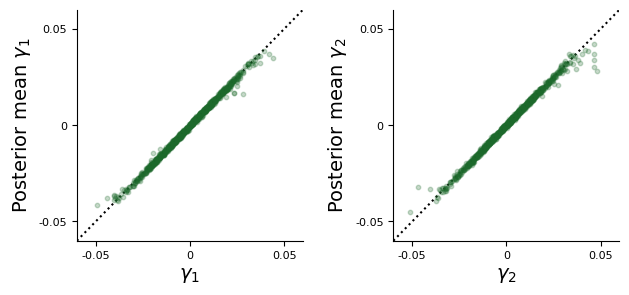

In [7]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting1.png"
)

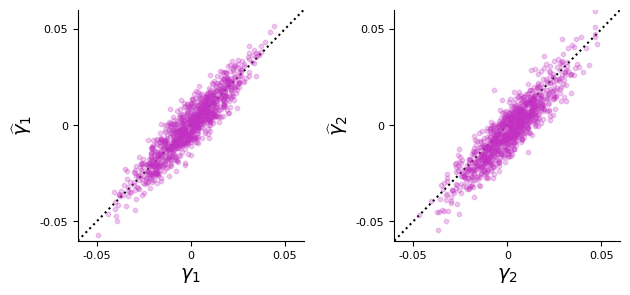

In [8]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_anacal, shear2_anacal,
    color="#c231c2",
    ylabel_template=r"$\widehat{{\gamma}}_{i}$",
    save_path="figures/anacal_scatterplots_setting1.png"
)

### **Setting 2**

In [9]:
setting2_npe = torch.load("npe_credible_intervals_setting2.pt", weights_only=False)

shear1_true = setting2_npe["shear1_true"]
shear2_true = setting2_npe["shear2_true"]
shear1_npe = setting2_npe["shear1_posteriormean"]
shear2_npe = setting2_npe["shear2_posteriormean"]

setting2_anacal = torch.load("anacal_results_setting2.pt", weights_only=False)
e1_avg = setting2_anacal["e1_sum"] / setting2_anacal["num_detections"]
e2_avg = setting2_anacal["e2_sum"] / setting2_anacal["num_detections"]
R1 = setting2_anacal["e1g1_sum"].sum() / setting2_anacal["num_detections"].sum()
R2 = setting2_anacal["e2g2_sum"].sum() / setting2_anacal["num_detections"].sum()
shear1_anacal = torch.tensor(e1_avg / R1)
shear2_anacal = torch.tensor(e2_avg / R2)

_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")
_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_anacal, shear2_anacal, "AnaCal")

=== NPE ===
Shear 1: RMSE = 0.001215, Pearson r = 0.996742
         c ± 3SE = 0.000051 ± 0.000036, m ± 3SE = -0.002858 ± 0.002421
Shear 2: RMSE = 0.001427, Pearson r = 0.995594
         c ± 3SE = -0.000274 ± 0.000042, m ± 3SE = -0.012273 ± 0.002791

=== AnaCal ===
Shear 1: RMSE = 0.007386, Pearson r = 0.903210
         c ± 3SE = 0.001074 ± 0.000219, m ± 3SE = 0.022047 ± 0.014572
Shear 2: RMSE = 0.007574, Pearson r = 0.892122
         c ± 3SE = -0.000230 ± 0.000227, m ± 3SE = 0.001148 ± 0.015212



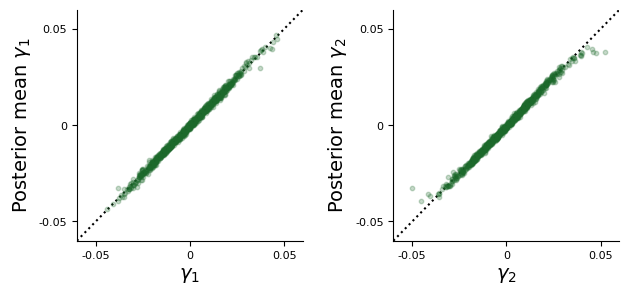

In [10]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting2.png"
)

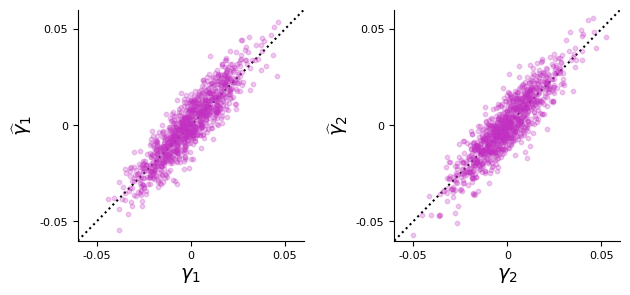

In [11]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_anacal, shear2_anacal,
    color="#c231c2",
    ylabel_template=r"$\widehat{{\gamma}}_{i}$",
    save_path="figures/anacal_scatterplots_setting2.png"
)

### **Setting 3**

In [12]:
setting3_npe = torch.load("npe_credible_intervals_setting3.pt", weights_only=False)

shear1_true = setting3_npe["shear1_true"]
shear2_true = setting3_npe["shear2_true"]
shear1_npe = setting3_npe["shear1_posteriormean"]
shear2_npe = setting3_npe["shear2_posteriormean"]

_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")

=== NPE ===
Shear 1: RMSE = 0.002300, Pearson r = 0.989089
         c ± 3SE = -0.000641 ± 0.000066, m ± 3SE = 0.000910 ± 0.004473
Shear 2: RMSE = 0.002346, Pearson r = 0.988820
         c ± 3SE = 0.000740 ± 0.000065, m ± 3SE = -0.038440 ± 0.004350



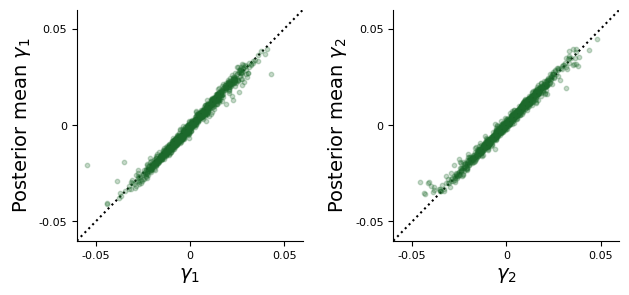

In [13]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting3.png"
)

### **Setting 4**

In [14]:
setting4_npe = torch.load("npe_credible_intervals_setting4.pt", weights_only=False)

shear1_true = setting3_npe["shear1_true"]
shear2_true = setting3_npe["shear2_true"]
shear1_npe = setting3_npe["shear1_posteriormean"]
shear2_npe = setting3_npe["shear2_posteriormean"]

_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")

=== NPE ===
Shear 1: RMSE = 0.002300, Pearson r = 0.989089
         c ± 3SE = -0.000641 ± 0.000066, m ± 3SE = 0.000910 ± 0.004473
Shear 2: RMSE = 0.002346, Pearson r = 0.988820
         c ± 3SE = 0.000740 ± 0.000065, m ± 3SE = -0.038440 ± 0.004350



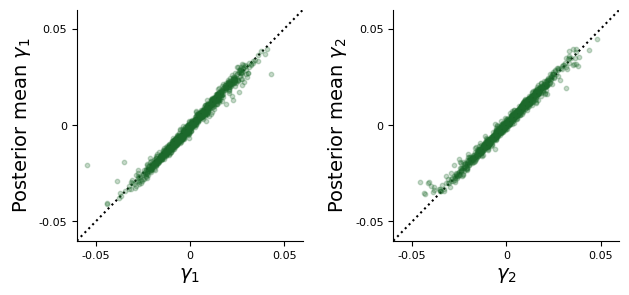

In [15]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting4.png"
)

### **Setting 5**

In [16]:
setting5_npe = torch.load("npe_credible_intervals_setting5.pt", weights_only=False)

shear1_true = setting5_npe["shear1_true"]
shear2_true = setting5_npe["shear2_true"]
shear1_npe = setting5_npe["shear1_posteriormean"]
shear2_npe = setting5_npe["shear2_posteriormean"]

_ = compute_and_print_metrics(shear1_true, shear2_true, shear1_npe, shear2_npe, "NPE")

=== NPE ===
Shear 1: RMSE = 0.002574, Pearson r = 0.985600
         c ± 3SE = 0.000365 ± 0.000073, m ± 3SE = -0.052423 ± 0.004878
Shear 2: RMSE = 0.002772, Pearson r = 0.984479
         c ± 3SE = 0.000308 ± 0.000074, m ± 3SE = -0.083343 ± 0.004903



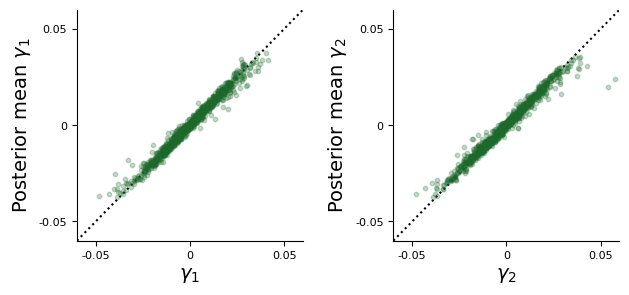

In [17]:
plot_scatterplot(
    shear1_true, shear2_true, shear1_npe, shear2_npe,
    color="#1c692b",
    ylabel_template=r"Posterior mean $\gamma_{i}$",
    save_path="figures/npe_scatterplots_setting5.png"
)